# Individual Project: Unsupervised CT Denoising with CycleGAN
This notebook is provided for unsupervised CT denoising task with cycleGAN.

###Table of Contents

I. Data: Google Drive, Dataloader

II. Network: Generator / Discriminator

III. Other functions

IV. Training

V. Test

## I. Data

### 1. Google Drive
If you want to use data in your Google drive, you have to mount your google drive first.
It makes possible to load data from the drive, save results in the drive, etc.
If you try to mount Google Drive, a link for authentication code will be given.
Then, follow the link, get your authentication code, and enter your code in the prompt.

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Now, define the directory address you're working on.

In [1]:
your_workdir = ''    # change this accordingly!

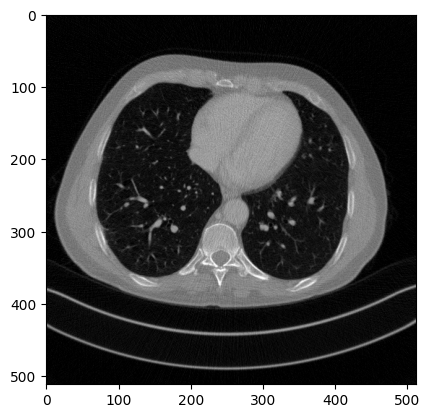

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load an example image
img = np.load(your_workdir+'AAPM_data_2025F/train/full_dose/1.npy')

# Change linear attenuation coefficient into HU values
img = (img - 0.0192) / 0.0192 * 1000
# Clip the CT image with [-1000, 1000] HU
img = np.clip(img, -1000, 1000)

# Plot the example image
plt.imshow(img, cmap='gray')
plt.show()

### 2. Dataloader
Before the training of cycleGAN, data preprocessing (e.g. cliping, normalization) is required.


In [3]:
import random
from os import listdir
from os.path import join
from torch.utils.data import Dataset


# CT dataset
class CT_Dataset(Dataset):
  def __init__(self, path, transform):
    # Path of 'full_dose' and 'quarter_dose' folders
    self.path_full = join(path, 'full_dose')
    self.path_quarter = join(path, 'quarter_dose')
    self.transform = transform

    # File list of full dose data
    self.file_full = list()
    for file_name in sorted(listdir(self.path_full)):
      self.file_full.append(file_name)
    random.seed(0)
    random.shuffle(self.file_full)

    # File list of quarter dose data
    self.file_quarter = list()
    for file_name in sorted(listdir(self.path_quarter)):
      self.file_quarter.append(file_name)

  def __len__(self):
    return min(len(self.file_full), len(self.file_quarter))

  def __getitem__(self, idx):
    # Load full dose/quarter dose data
    x_F = np.load(join(self.path_full, self.file_full[idx]))
    x_Q = np.load(join(self.path_quarter, self.file_quarter[idx]))

    # Convert to HU scale
    x_F = (x_F - 0.0192) / 0.0192 * 1000
    x_Q = (x_Q - 0.0192) / 0.0192 * 1000

    # Normalize images
    x_F[x_F < -1000] = -1000
    x_Q[x_Q < -1000] = -1000

    x_F = x_F / 4000
    x_Q = x_Q / 4000

    # Apply transform
    x_F = self.transform(x_F)
    x_Q = self.transform(x_Q)

    file_name = self.file_quarter[idx]

    return x_F, x_Q, file_name

Because the size of CT images is too large, we have to crop the images into small size patches for training.
After training with patches, the whole size image will be used for the test.

In [4]:
import random
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF


# Transform for the random crop
class RandomCrop(object):
  def __init__(self, patch_size):
    self.patch_size = patch_size

  def __call__(self, img):
    # Randomly crop the image into a patch with the size [self.patch_size, self.patch_size]
    w, h = img.size(-1), img.size(-2)
    i = random.randint(0, h - self.patch_size)
    j = random.randint(0, w - self.patch_size)

    return img[:, i:i + self.patch_size, j:j + self.patch_size]

# Make dataloader for training/test
def make_dataloader(path, batch_size):
  # Path of 'train' and 'test' folders
  path_train = join(path, 'train')
  path_test = join(path, 'test')

  # Transform for training data: convert to tensor, random horizontal/verical flip, random crop
  # You can change transform if you want.
  train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    RandomCrop(128)
  ])

  # Transform for test data: convert to tensor
  test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])

  # Generate CT dataset for training/test
  train_dataset = CT_Dataset(path_train, train_transform)
  test_dataset = CT_Dataset(path_test, test_transform)

  # Generate dataloader for training/test
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
  test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

  return train_dataloader, test_dataloader

In [5]:
train_dataloader, test_dataloader = make_dataloader("AAPM_data_2025F",32)

## II. Network: Generator / Discriminator
You have to implement basic blocks for generator/discriminator.
Refer to the 'ConvBlock', and make your own blocks for building generators/discriminators.

In [6]:
import torch
import torch.nn as nn

""" CONVOLUTIONAL LAYERS BLOCK """
##############################################################################################################
class ConvBlock(nn.Module): # For Standard U-Net
  def __init__(self, in_channels, out_channels):
    super(ConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels, affine=True, track_running_stats=True),
        nn.ReLU()
    )
  def forward(self, x):
    out = self.conv(x)
    return out

class ResBlock(nn.Module): # For ResU-Net (Residual Dense U-Net) with local residual path
  def __init__(self, in_channels, out_channels):
    super(ResBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels, affine=True, track_running_stats=True)
    )
    self.shortcut = nn.Identity()
    if in_channels != out_channels:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels, affine=True, track_running_stats=True)
        )
    self.relu = nn.ReLU()
  def forward(self, x):
    residual = self.shortcut(x)
    out = self.conv(x)
    out = out + residual
    out = self.relu(out)
    return out

class AttentionGate(nn.Module): # For Attention U-Net (U-Net with Attention Gate)
    def __init__(self, in_channels, gating_channels, inter_channels=None):
        super().__init__()
        if inter_channels is None:
            inter_channels = in_channels // 2
    
        self.W_g = nn.Sequential(
            nn.Conv2d(gating_channels, inter_channels, kernel_size=1),
            nn.BatchNorm2d(inter_channels, affine=True)  # ← Fixed
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, kernel_size=1),
            nn.BatchNorm2d(inter_channels, affine=True)  # ← Fixed
        )
        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, kernel_size=1),
            nn.Sigmoid()  # ← Removed BatchNorm2d(1) — safer and standard
        )
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(torch.relu(g1 + x1))
        return x * psi
##############################################################################################################

""" ENCODER & DECODER """
##############################################################################################################
class encoder_block(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = ConvBlock(in_channels, out_channels)
    # self.conv = ResBlock(in_channels, out_channels) # --> Uncomment this, for ResU-Net implementation
    self.pool = nn.MaxPool2d((2, 2))
  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.pool(x)
    return x, p 

class decoder_block(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
    # self.attention = AttentionGate(out_channels, out_channels) # --> Uncomment this, to enable Attention Gate
    self.conv = ConvBlock(out_channels*2, out_channels)
    # self.conv = ResBlock(out_channels*2, out_channels) # --> Uncomment this, for ResU-Net implementation
  def forward(self, inputs, skip):
    x = self.up(inputs)
    # skip = self.attention(skip, x) # --> Uncomment this, to enable Attention Gate
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x
##############################################################################################################

### 1. Generator
Now, implement the generator and discriminator below.
You are free to choose the structure of the generator (e.g. U-Net, ResNet), but it should contain residual path.

In [7]:
""" GENERATOR """
class Generator(nn.Module):
  def __init__(self, in_channels=1, out_channels=1, ngf=64):
    super(Generator, self).__init__()
    # in_channels: the number of channels of the input
    # out_channels: the number of channels of the output
    # ngf: the number of convolution filters of the first layer
    ######################
    """ Encoder """
    self.enc1 = encoder_block(in_channels, ngf)
    self.enc2 = encoder_block(ngf, ngf*2)
    self.enc3 = encoder_block(ngf*2, ngf*4)
    self.enc4 = encoder_block(ngf*4, ngf*8)
    """ Bottleneck """
    self.bk = ConvBlock(ngf*8, ngf*16)
    """ Decoder """
    self.dec1 = decoder_block(ngf*16, ngf*8)
    self.dec2 = decoder_block(ngf*8, ngf*4)
    self.dec3 = decoder_block(ngf*4, ngf*2)
    self.dec4 = decoder_block(ngf*2, ngf)
    """ Output """
    self.outputs = nn.Conv2d(ngf, out_channels, kernel_size=1, padding=0)
    ######################

  def forward(self, x):
    ######################
    """ Encoder """
    s1, p1 = self.enc1(x)
    s2, p2 = self.enc2(p1)
    s3, p3 = self.enc3(p2)
    s4, p4 = self.enc4(p3)
    """ Bottleneck """
    b = self.bk(p4)
    """ Decoder """
    d1 = self.dec1(b, s4)
    d2 = self.dec2(d1, s3)
    d3 = self.dec3(d2, s2)
    d4 = self.dec4(d3, s1)
    """ Outputs """
    res = self.outputs(d4)
    out = res + x
    ######################
    return out

In [8]:
in_channels  = 1
out_channels = 1
ngf          = 64
B, C, H, W   = 16, in_channels, 128,128

generator_test = Generator(1, 1, ngf)
print(generator_test)

x_test = torch.randn(B, C, H, W)
print('input shape: ', x_test.shape, '| dtype: ', x_test.dtype)

output = generator_test(x_test)
print('output shape: ', output.shape, '| dtype: ', output.dtype)

Generator(
  (enc1): encoder_block(
    (conv): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): encoder_block(
    (conv): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNo

### 2. Discriminator
You have to construct PatchGAN structure for the discriminator as shown in PPT slide.

In [9]:
# Discriminator (PatchGAN)
class Discriminator(nn.Module):
  def __init__(self, in_channels, ndf):
    super(Discriminator, self).__init__()
    # in_channels: the number of channels of the input
    # ndf: the number of convolution filters of the first layer
    ######################
    # Your code
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, ndf, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2, True),
        nn.Conv2d(ndf , ndf*2, kernel_size=4, stride=2, padding=1, bias=False), nn.InstanceNorm2d(ndf*2, affine=True), nn.LeakyReLU(0.2, True),
        nn.Conv2d(ndf*2 , ndf*4, kernel_size=4, stride=2, padding=1, bias=False), nn.InstanceNorm2d(ndf*4, affine=True), nn.LeakyReLU(0.2, True),
        nn.Conv2d(ndf*4 , ndf*8, kernel_size=4, stride=1, padding=1, bias=False), nn.InstanceNorm2d(ndf*8, affine=True), nn.LeakyReLU(0.2, True),
        nn.Conv2d(ndf*8 , 1, kernel_size=4, stride=1, padding=1, bias=False)
    )
    ######################

  def forward(self, x):
    ######################
    # Your code
    out = self.conv(x)
    return out
    ######################

In [10]:
in_channels  = 1
ndf          = 64
B, C, H, W   = 1, in_channels, 128, 128

discriminator_test = Discriminator(in_channels, ndf)
print(discriminator_test)

x_test = torch.randn(1, C, H, W)
print('input shape: ', x_test.shape, '| dtype: ', x_test.dtype)

output = discriminator_test(x_test)
print('output shape: ', output.shape, '| dtype: ', output.dtype)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)
input shape:  torch.Size([1, 1, 12

## III. Other functions


In [11]:
from torch.nn import init
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# initialize parameters of neural networks
def init_weights(net):
  def init_func(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
      init.normal_(m.weight.data, 0.0, 0.02)
      if hasattr(m, 'bias') and m.bias is not None:
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
      init.normal_(m.weight.data, 1.0, 0.02)
      init.constant_(m.bias.data, 0.0)

  print('Initialize network.')
  net.apply(init_func)


# Calculate average loss during one epoch
class Mean:
  def __init__(self):
    self.numel = 0
    self.mean = 0

  def __call__(self, val):
    self.mean = self.mean * (self.numel / (self.numel + 1)) + val / (self.numel + 1)
    self.numel += 1

  def result(self):
    return self.mean


# Show input and output images during training
def show_imgs(imgs):
  FQF = np.concatenate(imgs[:3], axis=2)
  QFQ = np.concatenate(imgs[3:], axis=2)
  img_array = np.squeeze(np.concatenate([FQF, QFQ], axis=1))

  img_array = img_array * 4000
  img_array = np.clip(img_array, -1000, 1000)

  plt.imshow(img_array, cmap='gray')
  plt.show()


# Set 'requires_grad' of the networks
def set_requires_grad(nets, requires_grad=False):
  if not isinstance(nets, list):
    nets = [nets]
  for net in nets:
    if net is not None:
      for param in net.parameters():
        param.requires_grad = requires_grad


# Functions for caculating PSNR, SSIM
def psnr(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = peak_signal_noise_ratio(ref, A)
  return out

def ssim(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = structural_similarity(ref, A, data_range=2)
  return out

## IV. Training
Before training the network, some hyperparameters should be defined as follows.
You can change the value of hyperparameters if you want.

In [12]:
from os import makedirs
from os.path import isdir

# Hyperparameters
# You can change hyperparameters to find your best performance in your architecture.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 16
lambda_cycle = 30
lambda_iden = 1
beta1 = 0.5
beta2 = 0.999
num_epoch = 1000
lr_G = 1e-4
lr_D = 2e-4
ngf = 64
ndf = 64
patient = 30

# Path for saving the checkpoint
path_checkpoint = your_workdir + "CT_denoising/" 
if not isdir(path_checkpoint):
  makedirs(path_checkpoint)

```model_name``` is the name of the model, and it will be used for saving the model.
If you want to continue the training from the last checkpoint, set ```model_name``` as the name of the saved model.
However, if you want to train a new model, you have to change ```model_name```.

In [13]:
model_name = 'CycleGAN'

# Path for saving results
path_result = join(path_checkpoint, model_name)
if not isdir(path_result):
  makedirs(path_result)

In [14]:
# Define the Learning Rate scheduler

class LambdaLR:
    def __init__(
        self,
        n_epochs, 
        offset=0,  
        decay_start_epoch=100, 
    ):
        assert (
            n_epochs - decay_start_epoch
        ) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (
            self.n_epochs - self.decay_start_epoch
        )

Next, make dataloaders, networks, optimizers, and define loss functions.

In [15]:
import itertools

# path of dataset (change the path according to your setting)
path_data = your_workdir+'AAPM_data_2025F'

# Make dataloaders
train_dataloader, test_dataloader = make_dataloader(path_data, batch_size)

# Make generators (G_F2Q: full to quarter / G_Q2F: quarter to full)
####################
G_F2Q = Generator(1, 1, ngf).to(device)
G_Q2F = Generator(1, 1, ngf).to(device)
####################

# Make discriminators (D_F: distinguish real/fake full dose images / D_Q: distinguish real/fake quarter dose images)
####################
D_F = Discriminator(1, ndf).to(device)
D_Q = Discriminator(1, ndf).to(device)
####################

# Make optimizers
G_optim = torch.optim.Adam(itertools.chain(G_F2Q.parameters(), G_Q2F.parameters()), lr_G, betas=(beta1, beta2))
D_optim = torch.optim.Adam(itertools.chain(D_F.parameters(), D_Q.parameters()), lr_D, betas=(beta1, beta2))

# Define loss functions
adv_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
iden_loss = nn.L1Loss()

# Loss functions
loss_name = ['G_adv_loss_F',
             'G_adv_loss_Q',
             'G_cycle_loss_F',
             'G_cycle_loss_Q',
             'G_iden_loss_F',
             'G_iden_loss_Q',
             'D_adv_loss_F',
             'D_adv_loss_Q']

/mnt/hdd/hanif/anaconda3/envs/midterm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Start from save model - 203


Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [10:49<00:00,  5.42s/it]

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [10:34<00:00,  5.29s/it]

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [10:16<00:00,  5.14s/it]

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [10:57<00:00,  5.48s/it]

Step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

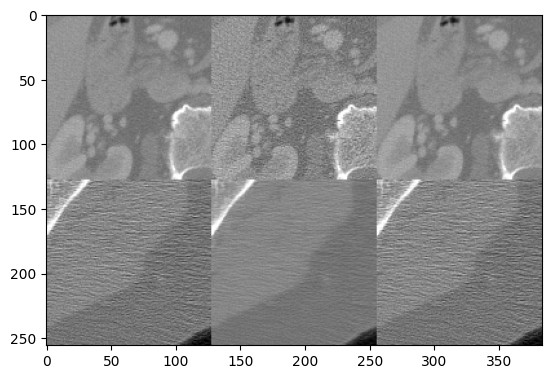

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [10:59<00:00,  5.50s/it]

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [10:42<00:00,  5.35s/it]

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [11:13<00:00,  5.61s/it]

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [11:01<00:00,  5.51s/it]

Step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

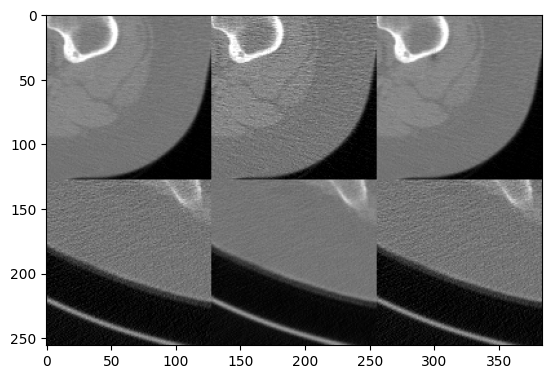

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [11:22<00:00,  5.69s/it]

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [10:45<00:00,  5.38s/it]

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [10:31<00:00,  5.27s/it]

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [10:43<00:00,  5.36s/it]

Step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

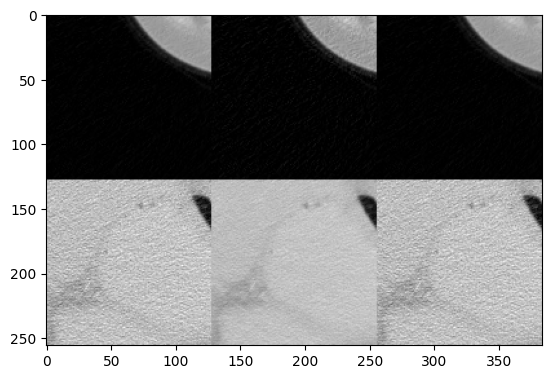

Step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [11:03<00:00,  5.53s/it]

Step:  13%|██████████████████████                                                                                                                                               | 16/120 [01:30<08:10,  4.72s/it]

In [ ]:
from os.path import isfile
from tqdm.auto import tqdm
import pandas as pd

# Load the last checkpoint if it exists
if isfile(join(path_checkpoint, model_name + '.pth')):
  checkpoint = torch.load(join(path_checkpoint, model_name + '.pth'))
  G_F2Q.load_state_dict(checkpoint['G_F2Q_state_dict'])
  G_Q2F.load_state_dict(checkpoint['G_Q2F_state_dict'])
  D_F.load_state_dict(checkpoint['D_F_state_dict'])
  D_Q.load_state_dict(checkpoint['D_Q_state_dict'])
  G_optim.load_state_dict(checkpoint['G_optim_state_dict'])
  D_optim.load_state_dict(checkpoint['D_optim_state_dict'])
  trained_epoch = checkpoint['epoch']
  losses_list = {name: torch.load(join(path_result, name + '.npy')) for name in loss_name}
  print('Start from save model - ' + str(trained_epoch))
# If the checkpoint does not exist, start the training with random initialized model
else:
  init_weights(G_F2Q)
  init_weights(G_Q2F)
  init_weights(D_F)
  init_weights(D_Q)
  trained_epoch = 0
  losses_list = {name: list() for name in loss_name}
  print('Start from random initialized model')

# optim-scheduler
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(G_optim, lr_lambda=LambdaLR(num_epoch).step)
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(D_optim, lr_lambda=LambdaLR(num_epoch).step)


psnr_all_list = []
ssim_all_list = []
e_count=patient
psnr_best=0
for epoch in tqdm(range(trained_epoch, num_epoch), desc='Epoch', total=num_epoch, initial=trained_epoch):
  losses = {name: Mean() for name in loss_name}

  for x_F, x_Q, _ in tqdm(train_dataloader, desc='Step'):
    x_F = x_F.to(device)
    x_Q = x_Q.to(device)

    # Set 'requires_grad' of the discriminators as 'False'
    ####################
    D_F.requires_grad_(False)
    D_Q.requires_grad_(False)
    G_Q2F.train()
    ####################

    x_FQ = G_F2Q(x_F)
    x_QF = G_Q2F(x_Q)
    x_QFQ = G_F2Q(x_QF)
    x_FQF = G_Q2F(x_FQ)
    x_QQ = G_F2Q(x_Q)
    x_FF = G_Q2F(x_F)
    
    dF_x_QF = D_F(x_QF)
    dQ_x_FQ = D_Q(x_FQ)

    G_adv_loss_F = nn.MSELoss()(dF_x_QF, torch.ones_like(dF_x_QF))
    G_adv_loss_Q = nn.MSELoss()(dQ_x_FQ, torch.ones_like(dQ_x_FQ))
    G_cycle_loss_F = nn.L1Loss()(x_FQF, x_F)
    G_cycle_loss_Q = nn.L1Loss()(x_QFQ, x_Q)
    G_iden_loss_F = nn.L1Loss()(x_FF, x_F)
    G_iden_loss_Q = nn.L1Loss()(x_QQ, x_Q)
    G_adv_loss = G_adv_loss_F + G_adv_loss_Q
    G_cycle_loss = G_cycle_loss_F + G_cycle_loss_Q
    G_iden_loss = G_iden_loss_F + G_iden_loss_Q
    G_total_loss = G_adv_loss_F + G_adv_loss_Q + lambda_cycle * (G_cycle_loss) + lambda_iden * (G_iden_loss)

    G_optim.zero_grad()
    G_total_loss.backward()
    G_optim.step()

    # Set 'requires_grad' of the discriminators as 'True'
    ####################
    D_F.requires_grad_(True)
    D_Q.requires_grad_(True)
    ####################

    d_F_x_F = D_F(x_F.detach())
    d_F_x_QF = D_F(x_QF.detach())
    d_Q_x_Q = D_Q(x_Q.detach())
    d_Q_x_FQ = D_Q(x_FQ.detach())
      

    # You have to detach the outputs of the generators in below codes
    D_adv_loss_F = nn.MSELoss()(d_F_x_F, torch.ones_like(d_F_x_F)) + nn.MSELoss()(d_F_x_QF,torch.zeros_like(d_F_x_QF))
    D_adv_loss_Q = nn.MSELoss()(d_Q_x_Q, torch.ones_like(d_Q_x_Q)) + nn.MSELoss()(d_Q_x_FQ,torch.zeros_like(d_Q_x_FQ))
    D_total_loss_F = D_adv_loss_F / 2.0
    D_total_loss_Q = D_adv_loss_Q / 2.0

    D_optim.zero_grad()
    D_total_loss_F.backward()
    D_total_loss_Q.backward()
    D_optim.step()

    # Calculate the average loss during one epoch
    losses['G_adv_loss_F'](G_adv_loss_F.detach())
    losses['G_adv_loss_Q'](G_adv_loss_Q.detach())
    losses['G_cycle_loss_F'](G_cycle_loss_F.detach())
    losses['G_cycle_loss_Q'](G_cycle_loss_Q.detach())
    losses['G_iden_loss_F'](G_iden_loss_F.detach())
    losses['G_iden_loss_Q'](G_iden_loss_Q.detach())
    losses['D_adv_loss_F'](D_adv_loss_F.detach())
    losses['D_adv_loss_Q'](D_adv_loss_Q.detach())

  for name in loss_name:
    losses_list[name].append(losses[name].result())

  # Update learning rates
  lr_scheduler_G.step()
  lr_scheduler_D.step()

  # Save models checkpoints
  psnr_list = []
  ssim_list = []
  G_Q2F.eval()
  with torch.no_grad():
    for x_F_, x_Q_, filename in tqdm(test_dataloader):
        try:
            x_Q_ = x_Q_.to(device)
            x_QF_ = G_Q2F(x_Q_)[0].detach().cpu().numpy()
            x_QF_ = x_QF_ * 4000
            x_QF_ = x_QF_.squeeze()
            path_full = join(path_data, 'test/full_dose', filename[0])
            full = np.load(path_full)
            full = (full - 0.0192) / 0.0192 * 1000
            psnr_list.append(psnr(x_QF_, full))
            ssim_list.append(ssim(x_QF_, full))
        except:
            pass

  # Append to array
  psnr_val = np.mean(psnr_list)
  ssim_val = np.mean(ssim_list)
  psnr_all_list.append(psnr_val)
  ssim_all_list.append(ssim_val)

  # Check condition
  if (psnr_val > psnr_best) and (psnr_val<40):
    psnr_best = psnr_val
    e_count = patient
    torch.save(G_Q2F, join(path_result,'best_G_Q2F.pth'))
  torch.save(G_Q2F, join(path_result,'latest_G_Q2F.pth'))

  # Save the trained model and list of losses
  pd.DataFrame({"PSNR":psnr_all_list,"SSIM":ssim_all_list}).to_csv(join(path_result,"learning_curve_psnr_ssim.csv"))
  torch.save({'epoch': epoch + 1, 'G_F2Q_state_dict': G_F2Q.state_dict(), 'G_Q2F_state_dict': G_Q2F.state_dict(),
              'D_F_state_dict': D_F.state_dict(), 'D_Q_state_dict': D_Q.state_dict(),
              'G_optim_state_dict': G_optim.state_dict(), 'D_optim_state_dict': D_optim.state_dict()}, join(path_checkpoint, model_name + '.pth'))
  for name in loss_name:
    torch.save(losses_list[name], join(path_result, name + '.npy'))
      
  # Plot input/output images every 10 epochs
  if (epoch + 1) % 10 == 0:
    imgs = [x_F[0].detach().cpu().numpy(), x_FQ[0].detach().cpu().numpy(), x_FQF[0].detach().cpu().numpy(),
            x_Q[0].detach().cpu().numpy(), x_QF[0].detach().cpu().numpy(), x_QFQ[0].detach().cpu().numpy()]
    show_imgs(imgs)

  e_count-=1
  if e_count<1:
    if (psnr_val>38):
        break
    else:
        e_count = patient

## V. Test
Last, you have to verify the performance of your network.

In [26]:
from tqdm.auto import tqdm

# Load the last checkpoint
checkpoint = torch.load(join(path_checkpoint, model_name + '.pth'))
G_Q2F.load_state_dict(checkpoint['G_Q2F_state_dict'])
G_Q2F.eval()

# Test and save
with torch.no_grad():
  for _, x_Q, file_name in tqdm(test_dataloader):
    x_Q = x_Q.to(device)
    x_QF = G_Q2F(x_Q)[0].detach().cpu().numpy()
    x_QF = x_QF * 4000

    np.save(join(path_result, file_name[0]), x_QF)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]


In [27]:
ll = 0
for img in test_dataloader:
    ll+=1
print(ll)

100


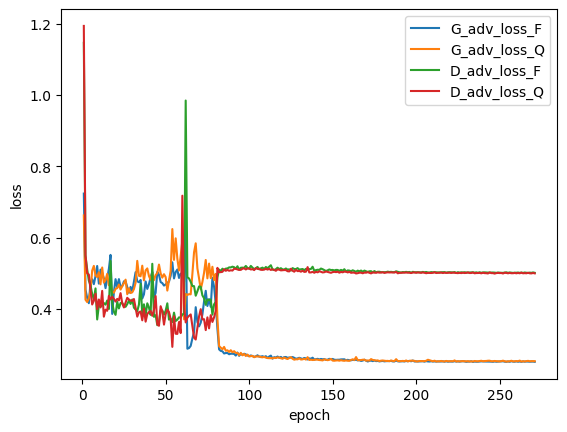

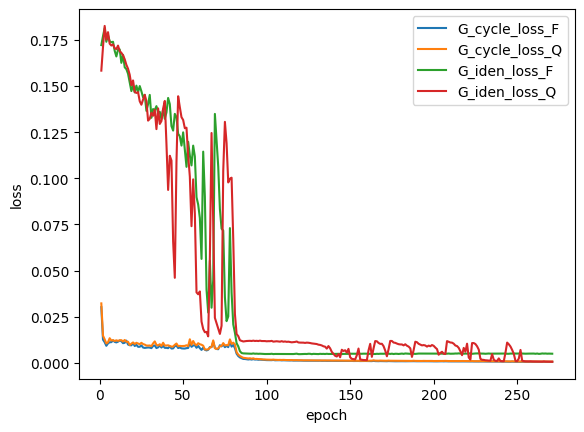

In [28]:
import matplotlib.pyplot as plt

# Plot loss graph (adversarial loss)
x_axis = np.arange(1, 271 + 1)
plt.figure(1)
for name in ['G_adv_loss_F', 'G_adv_loss_Q', 'D_adv_loss_F', 'D_adv_loss_Q']:
  loss_arr = torch.load(join(path_result, name + '.npy'))
  loss_arr = [i.to("cpu") for i in loss_arr]
  plt.plot(x_axis, loss_arr, label=name)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig(join(path_result, 'loss_curve_1.png'))
plt.show()

# Plot loss graph (cycle consistency loss, identity loss)
plt.figure(2)
for name in ['G_cycle_loss_F', 'G_cycle_loss_Q', 'G_iden_loss_F', 'G_iden_loss_Q']:
  loss_arr = torch.load(join(path_result, name + '.npy'))
  loss_arr = [i.to("cpu") for i in loss_arr]
  plt.plot(x_axis, loss_arr, label=name)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig(join(path_result, 'loss_curve_2.png'))
plt.show()

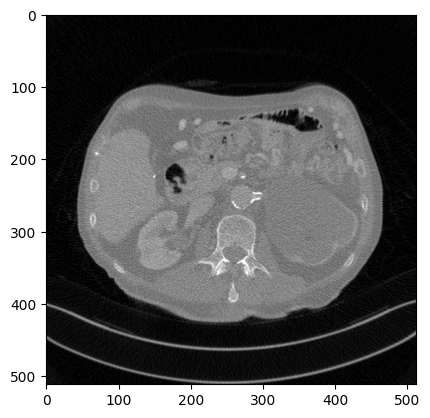

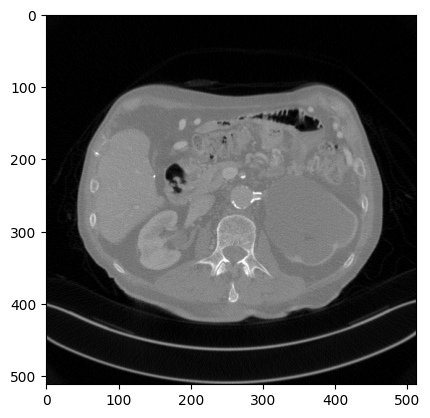

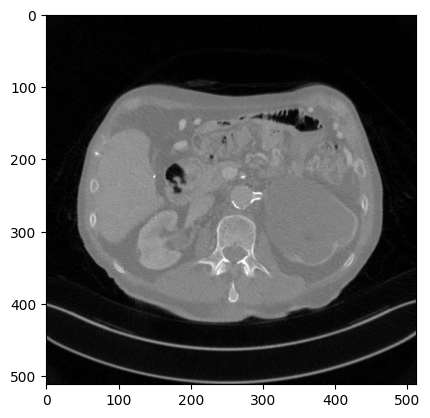

In [29]:
import matplotlib.pyplot as plt

# Example of result
path_quarter = join(path_data, 'test/quarter_dose/100.npy')
path_full = join(path_data, 'test/full_dose/100.npy')
path_output = join(path_result, '100.npy')

quarter = np.load(path_quarter)
full = np.load(path_full)
output = np.load(path_output)

quarter = (quarter - 0.0192) / 0.0192 * 1000
full = (full - 0.0192) / 0.0192 * 1000

quarter = np.clip(quarter, -1000, 1000)
full = np.clip(full, -1000, 1000)
output = np.clip(output, -1000, 1000)

plt.imshow(quarter, cmap='gray')
plt.show()
plt.imshow(full, cmap='gray')
plt.show()
plt.imshow(output.squeeze(), cmap='gray')
plt.show()

In [30]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Functions for caculating PSNR, SSIM
def psnr(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = peak_signal_noise_ratio(ref, A)
  return out

def ssim(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = structural_similarity(ref, A, data_range=2)
  return out

In [31]:
# How to use functions 'psnr' and 'ssim'
path_quarter = join(path_data, 'test/quarter_dose/100.npy')
path_full = join(path_data, 'test/full_dose/100.npy')
path_output = join(path_result, '100.npy')

quarter = np.load(path_quarter)
full = np.load(path_full)
output = np.load(path_output)

quarter = (quarter - 0.0192) / 0.0192 * 1000
full = (full - 0.0192) / 0.0192 * 1000

print(psnr(quarter, full))
print(ssim(quarter, full))
print(psnr(output.squeeze(), full))
print(ssim(output.squeeze(), full))

31.636385113829363
0.8593058539190875
36.43031305344163
0.9478096000594239


Calculate mean PSNR and SSIM of Quarter-dose and CycleGAN output for the entire test set, and see the performance difference.

In [32]:
###########################
import os
import re

# Collecting List
output_filenames = [filename for filename in os.listdir(join(path_result)) if (re.compile(r'^\d+' + r'\.npy$').match(filename)) and (filename in os.listdir(join(path_data,"test/full_dose")))]
output_path_list = [join(path_result,filename) for filename in output_filenames]
quarter_path_list = [join(path_data,"test/quarter_dose",filename) for filename in output_filenames]
full_path_list = [join(path_data,"test/full_dose",filename) for filename in output_filenames]
# Images Loading
output_images = [np.load(output_path) for output_path in output_path_list]
quarter_images = [np.load(quarter_path) for quarter_path in quarter_path_list]
full_images = [np.load(full_path) for full_path in full_path_list]
# Preprocessing
quarter_data = [((quarter - 0.0192) / 0.0192 * 1000) for quarter in quarter_images]
full_data = [((full - 0.0192) / 0.0192 * 1000) for full in full_images]
# Calculation
psnr_all_noisy = [psnr(quarter, full) for quarter, full in zip(quarter_data, full_data)]
ssim_all_noisy = [ssim(quarter, full) for quarter, full in zip(quarter_data, full_data)]
psnr_all_recon = [psnr(output.squeeze(), full) for output, full in zip(output_images, full_data)]
ssim_all_recon = [ssim(output.squeeze(), full) for output, full in zip(output_images, full_data)]
###########################

print('Average Noisy input PSNR:', np.mean(psnr_all_noisy))
print('Average Noisy input SSIM:', np.mean(ssim_all_noisy))
print('Average Denoised output PSNR:', np.mean(psnr_all_recon))
print('Average Denoised output SSIM:', np.mean(ssim_all_recon))
print('Estimated Score:', (np.mean(psnr_all_recon)/40)+np.mean(ssim_all_recon))


Average Noisy input PSNR: 34.66212290789607
Average Noisy input SSIM: 0.9234010212546991
Average Denoised output PSNR: 38.913721188089134
Average Denoised output SSIM: 0.9712958483588218
Estimated Score: 1.9441388780610502
